In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

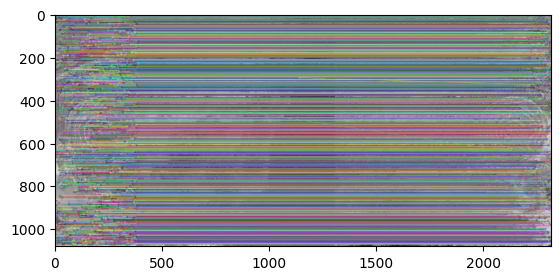

In [6]:
img_left = cv2.imread("1.png")
img_right = cv2.imread("2.png")

gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)

#SIFT para detectar keypoints
sift = cv2.SIFT_create()
kp_left, des_left = sift.detectAndCompute(gray_left, None) # Train
kp_rigth, des_right = sift.detectAndCompute(gray_right, None) # Query

# Matching Flann - es más rapido
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Derecha es Query
# Izquierda es nuestro train
matches = flann.knnMatch(des_right, des_left, k=2)

# print(len(matches))

# Lower Ratio Test

good_matches = []

for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Visualizar
img_matches = cv2.drawMatches(gray_right, kp_rigth, gray_left, kp_left, good_matches, None, flags=2)

plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))


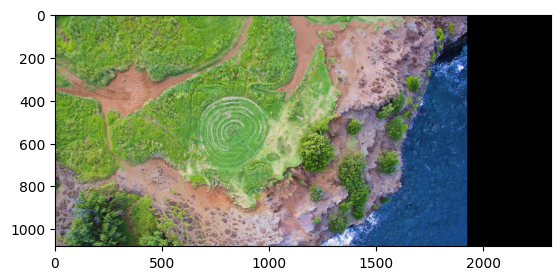

In [9]:
# Homografia

# Extract coorenates of X, Y

src_pts = np.float32([kp_rigth[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
dst_pts = np.float32([kp_left[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

# Ransac
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp * deformacion
# Calcular nuestro entorno o lienzo

h_left, w_left = img_left.shape[:2]
h_rigth, w_rigth = img_right.shape[:2]

# Ancho  = i1.w + i2.w
# Alto = de la imagen de imagen mas alta
canvas_w = w_left + w_rigth
canvas_h = max(h_left, h_rigth)

# Deformamos la imagen de la derecha, como la base es la izquierda
# La derecha se movera hacia coordenadas positivas

panorama = cv2.warpPerspective(img_right, M, (canvas_w, canvas_h))

# Deformacion

panorama[0:img_left.shape[0], 0:img_left.shape[1]] = img_left

dst_rgb = cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB)

plt.imshow(dst_rgb)
plt.show()

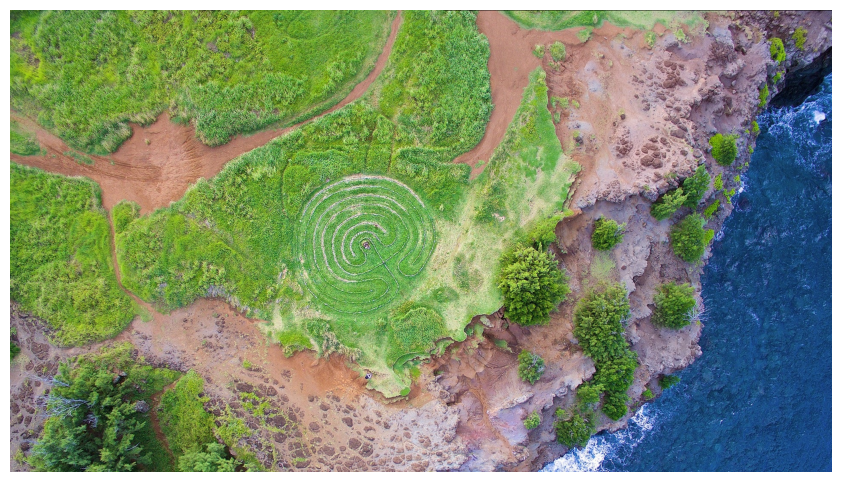

In [10]:
# Convertir panorama a escala de grises
panorama_gray = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)

# Crear máscara de contenido (pixeles distintos de negro)
_, mask_content = cv2.threshold(panorama_gray, 1, 255, cv2.THRESH_BINARY)

# Invertir máscara
mask_inv = cv2.bitwise_not(mask_content)

# Colocar imagen izquierda en el lienzo
left_on_canvas = np.zeros_like(panorama)
left_on_canvas[0:h_left, 0:w_left] = img_left

# Separar regiones
img_left_part = cv2.bitwise_and(left_on_canvas, left_on_canvas, mask=mask_inv)
img_right_part = cv2.bitwise_and(panorama, panorama, mask=mask_content)

# Combinar ambas imágenes
result = cv2.add(img_left_part, img_right_part)

# Encontrar coordenadas donde hay contenido
rows, cols = np.where(result[:, :, 0] != 0)

# Calcular límites del área válida
if len(rows) > 0 and len(cols) > 0:
    y_min, y_max = np.min(rows), np.max(rows)
    x_min, x_max = np.min(cols), np.max(cols)

    cropped_result = result[y_min:y_max, x_min:x_max]
else:
    cropped_result = result

# Visualizar resultado final
result_rgb = cv2.cvtColor(cropped_result, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,6))
plt.imshow(result_rgb)
plt.axis("off")
plt.show()